# MScFE 600 FINANCIAL DATA

This will focus on Scenario 1 (Credit Card Loan) and Scenario 2 (Mortgage Loan in California) along with necessary plots and statistical analysis.

## Setup and Data Import

This section sets up the environment and imports data for the two scenarios using FRED data and Yahoo Finance.

In [ ]:
import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yfin
import matplotlib.pyplot as plt
from scipy import stats

# Start and end dates for data collection
end = datetime.date.today()
start = end - datetime.timedelta(365 * 10)  # 10-year range

# Column mapping
column_name_mapping = {
    'DRCCLACBS': 'CreditCardDelinq (quarterly)',
    'MORTGAGE30US': 'AvgMortgageRate (weekly)',
    'DRSFRMACBS': 'MortgageDelinq (quarterly)',
    'CASTHPI': 'HousePxIdx_CA (quarterly)'
}

# Fetch data from FRED
df = web.DataReader(
    ['DRCCLACBS', 'MORTGAGE30US', 'DRSFRMACBS', 'CASTHPI'],
    'fred', start, end
)

# Rename columns
df.rename(columns=column_name_mapping, inplace=True)

# Display
df.head()

,CreditCardDelinq (quarterly),AvgMortgageRate (weekly),MortgageDelinq (quarterly),HousePxIdx_CA (quarterly)
DATE,,,,
2014-10-01,2.15,NaN,6.5,500.33
2014-10-02,NaN,4.19,NaN,NaN
2014-10-09,NaN,4.12,NaN,NaN
2014-10-16,NaN,3.97,NaN,NaN
2014-10-23,NaN,3.92,NaN,NaN


The above code sets up data for two key scenarios:

* Scenario 1: Credit card delinquency rates (DRCCLACBS) represent the risk of unsecured loans.
* Scenario 2: Mortgage data (MORTGAGE30US, DRSFRMACBS, CASTHPI) illustrates risk tied to housing loans in California.

Data is gathered from FRED.

## Visualizing the Data

In this section, we plot the time series data helps visualize trends and potential correlations.

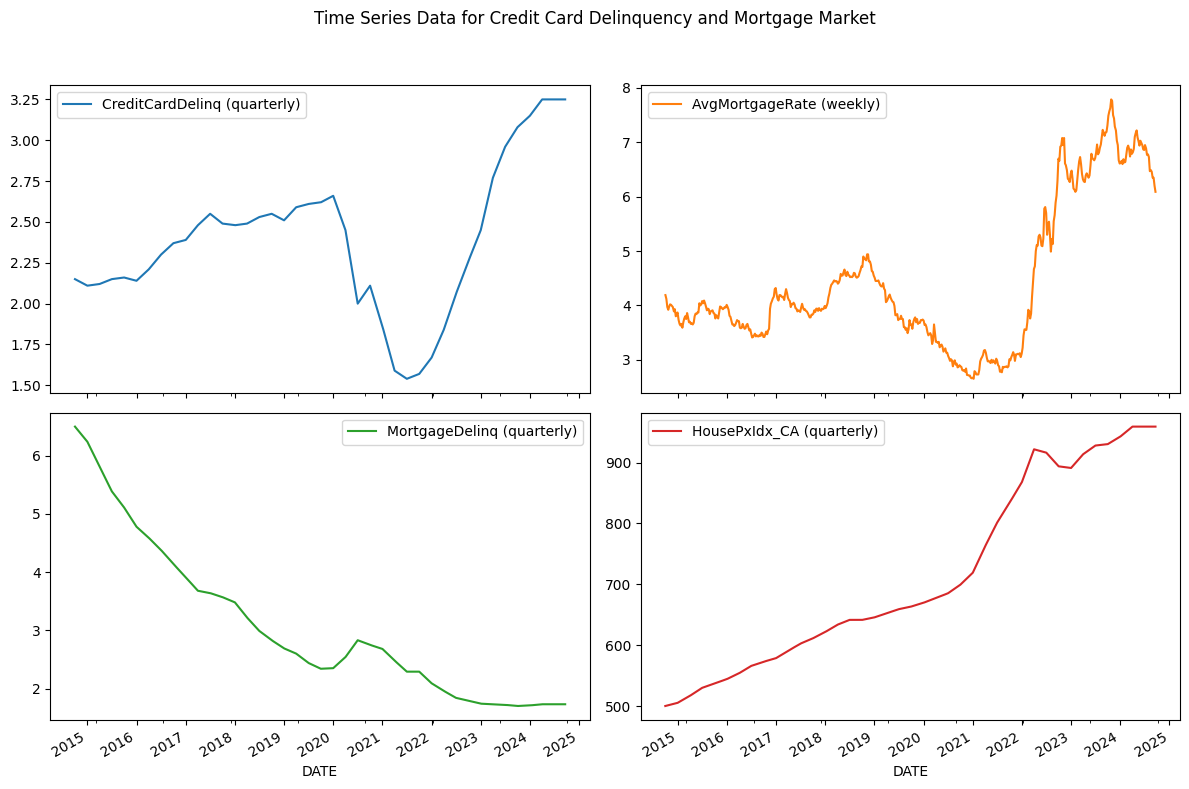

In [ ]:
# Interpolate data
df_interpolated = df.interpolate('index')

# Plot
df_interpolated.plot(subplots=True, layout=(2, 2), figsize=(12, 8))
plt.suptitle('Time Series Data for Credit Card Delinquency and Mortgage Market')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The above plot provides a clear view of how each economic indicator has evolved over the past decade.

## Handling Data Frequency Alignment
Since financial data often comes in various frequencies, aligning them properly is important.

In [ ]:
# Adjust time index
for feature in ['CreditCardDelinq (quarterly)', 'MortgageDelinq (quarterly)', 'HousePxIdx_CA (quarterly)']:
    clean_series = df[feature].dropna()
    df[feature] = pd.Series(clean_series.values, index=[d + BDay(0) for d in clean_series.index])

# Display
df.head()

,CreditCardDelinq (quarterly),AvgMortgageRate (weekly),MortgageDelinq (quarterly),HousePxIdx_CA (quarterly)
DATE,,,,
2014-10-01,2.15,NaN,6.5,500.33
2014-10-02,NaN,4.19,NaN,NaN
2014-10-09,NaN,4.12,NaN,NaN
2014-10-16,NaN,3.97,NaN,NaN
2014-10-23,NaN,3.92,NaN,NaN


Adjusting date indices ensures data points align correctly with business dayy.

## Calculating Returns

Calculating log returns helps normalize the data for consistent comparison.

In [ ]:
def calculate_returns(df):
    df_returns = np.log(df) - np.log(df.shift(1))
    return df_returns.dropna()

# Calculate returns for quarterly, weekly, and daily data
df_quarterly = df.drop(columns=['AvgMortgageRate (weekly)']).loc[df['CreditCardDelinq (quarterly)'].dropna().index].ffill()
df_weekly = df.loc[df['AvgMortgageRate (weekly)'].dropna().index,
                   ['AvgMortgageRate (weekly)']].ffill()

df_quarterly_returns = calculate_returns(df_quarterly)
df_weekly_returns = calculate_returns(df_weekly)

df_quarterly_returns.head()


,CreditCardDelinq (quarterly),MortgageDelinq (quarterly),HousePxIdx_CA (quarterly)
DATE,,,
2015-01-01,-0.018780,-0.040822,0.010419
2015-04-01,0.004728,-0.069680,0.022163
2015-07-01,0.014052,-0.076755,0.025197
2015-10-01,0.004640,-0.053346,0.013696
2016-01-01,-0.009302,-0.066759,0.013015


Log returns provide a standardized measure of changes across different timeframes.

## Correlation Analysis and Heatmap

Correlation analysis to identify relationships between different loan risk indicators.

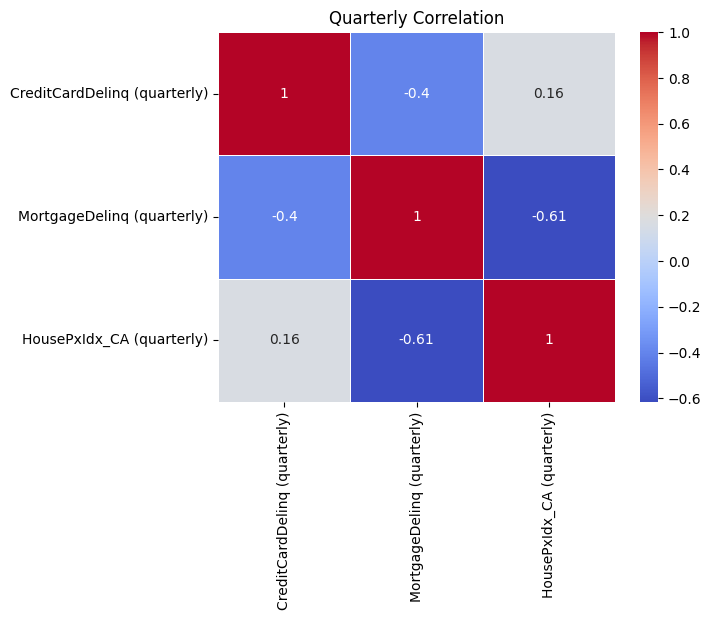

In [ ]:
def plot_correlation_heatmap(df_ret, title):
    corr_matrix = df_ret.corr().round(3)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title(title)
    plt.show()

# Plot correlation heatmaps
plot_correlation_heatmap(df_quarterly_returns, 'Quarterly Correlation')


Visualize relationships between variables to show how delinquency rates and market conditions might influence one another.

## Statistical Analysis of Returns

Basic statistical analysis to highlight nature of returns

In [ ]:
# Display skewness and basic statistics for daily returns
print(df_quarterly_returns.skew().rename('Skewness'))
print(df_quarterly_returns.describe())

CreditCardDelinq (quarterly)    1.560972
MortgageDelinq (quarterly)     -0.399725
HousePxIdx_CA (quarterly)       1.874404
Name: Skewness, dtype: float64
       CreditCardDelinq (quarterly)  MortgageDelinq (quarterly)  \
count                     25.000000                   25.000000   
mean                       0.016527                   -0.052947   
std                        0.114830                    0.071867   
min                       -0.202941                   -0.230016   
25%                       -0.015811                   -0.073272   
50%                        0.014052                   -0.050736   
75%                        0.032187                   -0.028676   
max                        0.424696                    0.108113   

       HousePxIdx_CA (quarterly)  
count                  25.000000  
mean                    0.026027  
std                     0.025547  
min                    -0.006017  
25%                     0.010506  
50%                     0.017569